In [1]:
import numpy as np
import matplotlib.pyplot as plt

import glow.lenses as lenses
import glow.mismatch  as mm
import glow.waveform as wf
import glow.tools as tools

cosmology={} # (dict) cosmological parameters, default is Planck18

import mismatch_plots_paper as mmp
mmp.set_latex_default(plt) # set default config to produce plots with latex style
mmp.initialize_cosmology(**cosmology)

import glow.physical_units as pu
# Initialize cosmology passing the cosmological parameters in the function below.
pu.initialize_cosmology(**cosmology)


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


FlatLambdaCDM(H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.04, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)

In [2]:
# setting up the unlensed waveform

# # # # LISA 

detector='LISA'
z_src_waveform= 5
Mtot=1e6
Mtot_detector= Mtot*(1+z_src_waveform)
q=1
spin=0
inc=0
Tobs= 0.21*pu.yr_to_s


# # # ET

# detector='ET'
# z_src_waveform= 0.6
# Mtot=50
# Mtot_detector= Mtot*(1+z_src_waveform)
# q=1
# spin=0
# inc=0
# Tobs=210


params_source= {'approximant': "IMRPhenomXHM",
            'q'              : q,
            'Mtot_src'       : Mtot,
            'Mtot_obs'       : Mtot_detector,
            'mass1'          : Mtot_detector * q/(1. + q),
            'mass2'          : Mtot_detector * 1/(1. + q),
            'spin1z'         : spin,
            'spin2z'         : spin,
            'redshift'       : z_src_waveform,
            'inclination'    : inc,
            'long_asc_nodes' : 0,
            'f_lower'        : np.amax([wf.f0_obs(Mtot_detector, Tobs, units='s'),wf.f_bounds_detector(detector)[0]]),
            'delta_f'        : 1/Tobs}

# A waveform is generated once a waveform object is initialized by the source parameters 
h_fd=wf.WaveformFD(params_source)
psd=wf.get_psd_from_file(detector) 
h_fd.load_psd(psd)

snr=h_fd.snr

/home/stefano/.local/lib/python3.10/site-packages/pycbc/types/array.py:217: RuntimeWarning: invalid value encountered in multiply
  ret = getattr(ufunc, method)(*inputs, **kwargs)


snr of the signal: 1248.7284406710978


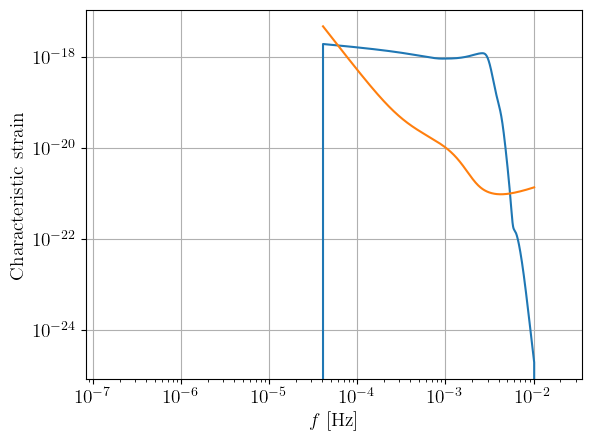

In [3]:
# !! Check that the signal meets the psd on the lhs

plt.loglog(h_fd.sample_frequencies,h_fd.sample_frequencies*np.abs(h_fd.p))
plt.loglog(h_fd.sample_frequencies,np.sqrt(h_fd.sample_frequencies*np.abs(h_fd.psd_grid)))
plt.xlabel('$f$ [Hz]')
plt.ylabel('Characteristic strain')
plt.grid()
print('snr of the signal:', h_fd.snr)

Produce critical curves

In [4]:
Psi_SIS = lenses.Psi_SIS()

MLzs=np.geomspace(1e2,1e11, 20) # LISA
# MLzs=np.geomspace(1e-3,1e7, 30) # LIGO, ET

s=1.
y_crits_SIS=mm.get_y_crit_curve_opt(h_fd, Psi_SIS, MLzs, 1, 200, s)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


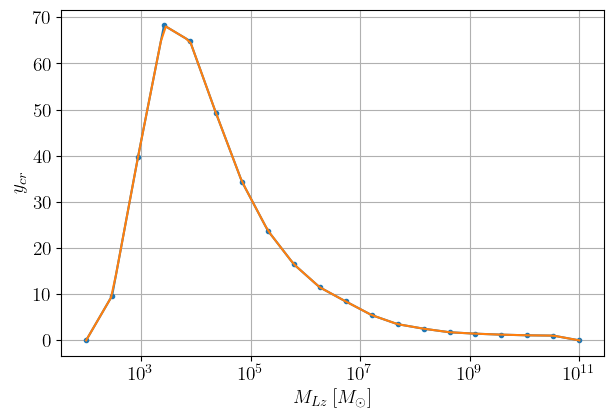

In [5]:
fig, ax = plt.subplots(1, figsize=(7, 4.5))

MLzs_new=np.geomspace(MLzs[0],MLzs[-1], 100)
ax.plot(MLzs, y_crits_SIS, label='SIS', marker='.')
ax.plot(MLzs_new, mm.get_interp_y_crit(MLzs, y_crits_SIS)(MLzs_new), label='interp SIS')

ax.set_ylabel('$y_{cr}$', fontsize=14)
ax.set_xlabel('$M_{Lz}\,[M_\odot]$', fontsize=14)
ax.set_yscale('linear')
ax.set_xscale('log')
ax.grid()

In [8]:
# Store mismatch grid

lens=Psi_SIS.p_phys['name']
lens_p=Psi_SIS.p_phys

save_dict={'detector':detector, 
      'lens':lens, 
      'MLzs':[MLzs], 
      'y_crits':[y_crits_SIS], 
      'mismatch_thr':s, 
      'params_source':params_source, 
      'params_lens':lens_p, 
      'dir':'ycr_bank/'}

mm.store_y_crit(save_dict)

In [49]:
detector='LISA'
psd=wf.get_psd_from_file(detector) 
Psi_SIS = lenses.Psi_SIS()
MLzs=np.geomspace(1e2,1e12, 20) # LISA

spin=0
inc=0
Tobs= 0.21*pu.yr_to_s
q=1

from tqdm import tqdm

for z in [3, 5, 8, 10]:
    print('z ', z)
    for Mtot in tqdm([1e5,1e6,1e7]):

        z_src_waveform= z

        Mtot_detector= Mtot*(1+z_src_waveform)

        params_source= {'approximant': "IMRPhenomXHM",
                    'q'              : q,
                    'Mtot_src'       : Mtot,
                    'Mtot_obs'       : Mtot_detector,
                    'mass1'          : Mtot_detector * q/(1. + q),
                    'mass2'          : Mtot_detector * 1/(1. + q),
                    'spin1z'         : spin,
                    'spin2z'         : spin,
                    'redshift'       : z_src_waveform,
                    'inclination'    : inc,
                    'long_asc_nodes' : 0,
                    'f_lower'        : np.amax([wf.f0_obs(Mtot_detector, Tobs, units='s'),wf.f_bounds_detector(detector)[0]]),
                    'delta_f'        : 1/Tobs,
                    'f_final':  7*wf.f_isco(Mtot_detector),
                    }
        
        mmp.produce_store_ycr_curve(Psi_SIS, MLzs, detector, params_source, psd)

z  3


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [03:12<00:00, 64.29s/it]


z  5


100%|██████████| 3/3 [01:50<00:00, 36.80s/it]


z  8


100%|██████████| 3/3 [01:18<00:00, 26.01s/it]


z  10


100%|██████████| 3/3 [01:05<00:00, 21.82s/it]


Figure 7

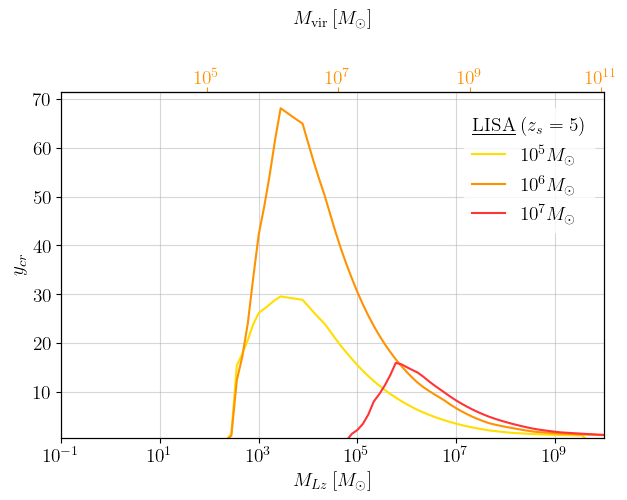

In [32]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(1, figsize=(7, 4.5))

# Specify lens type and directory
lens = 'SIS'
dir = 'ycr_bank/'
s=1

# Generate an array of MLz values
MLzs = np.geomspace(1e-1, 1e10, 100)

###############################################

# Settings for the first detector (LISA)
detector_1 = 'LISA'
z_src_1 = 5
Mtots_1 = [1e5, 1e6, 1e7]
c1_Mtot_s = ['#ffde00', '#ff9200', '#ff3535']

# Compose filenames and retrieve y_crit functions from stored vectors
filenames_read_1 = [mm.compose_filename(detector_1, lens, s, Mtot, z_src_1, dir=dir) for Mtot in Mtots_1]
y_crit_fun_1_s = mm.get_interp_y_crit_from_stored_vec(filenames_read_1)

# Plot y_crit curves for the first detector
plots_1 = mmp.plot_y_crit_vec(ax, MLzs, y_crit_fun_1_s, c1_Mtot_s)
labels_1, handles_1 = mmp.assemble_legend(Mtots_1, z_src_1, plots_1, detector_1)

# Add legend for the first detector
pos_1 = (1, 0.98)
mmp.add_legend_y_crit(ax, labels_1, handles_1, pos_1)

# Set ticks and appearance for the top x-axis for Mvir values for the first detector
ticks_Mvir_1 = [1e5, 1e7, 1e9, 1e11]
ax_Mvir_par_1 = [ticks_Mvir_1, c1_Mtot_s[1], "out", 0]
z_l_1 = z_src_1 / 2
ax_Mvir_1 = mmp.add_top_Mvirs_y_crit(ax, z_src_1, z_l_1, ax_Mvir_par_1)

# # ###############################################

# # Settings for the second detector (ET)
# detector_2 = 'ET'
# z_src_2 = 1
# Mtots_2 = [50, 100, 1e3]
# c2_Mtot_s = ['#6efaee', '#0099cc', '#0b377f']

# # Compose filenames and retrieve y_crit functions from stored vectors for the second detector
# filenames_read_2 = [mm.compose_filename(detector_2, lens, s, Mtot, z_src_2, dir=dir) for Mtot in Mtots_2]
# y_crit_fun_2_s = mm.get_interp_y_crit_from_stored_vec(filenames_read_2)

# # Plot y_crit curves for the second detector
# plots_2 = mmp.plot_y_crit_vec(ax, MLzs, y_crit_fun_2_s, c2_Mtot_s)
# labels_2, handles_2 = mmp.assemble_legend(Mtots_2, z_src_2, plots_2, detector_2)

# # Add legend for the second detector
# pos_2 = (1, 0.62)
# mmp.add_legend_y_crit(ax, labels_2, handles_2, pos_2)

# # Set ticks and appearance for the top x-axis for Mvir values for the second detector
# ticks_Mvir_2 = [1e3, 1e4, 1e5, 1e6]
# ax_Mvir_par_2 = [ticks_Mvir_2, c2_Mtot_s[1], "in", -20]
# z_l_2 = z_src_2 / 2
# ax_Mvir_2 = mmp.add_top_Mvirs_y_crit(ax, z_src_2, z_l_2, ax_Mvir_par_2)

# ###############################################

# Set the label for the top x-axis
ax_Mvir_1.set_xlabel(r'$M_{\rm vir}\,[M_\odot]$', fontsize=14, labelpad=33)

# Save 

if False:
    plt.savefig('plots/ycrit_'+detector_1+'_'+detector_2+'_Mbbh_s.pdf', dpi=700, bbox_inches='tight')
    


Figure 8

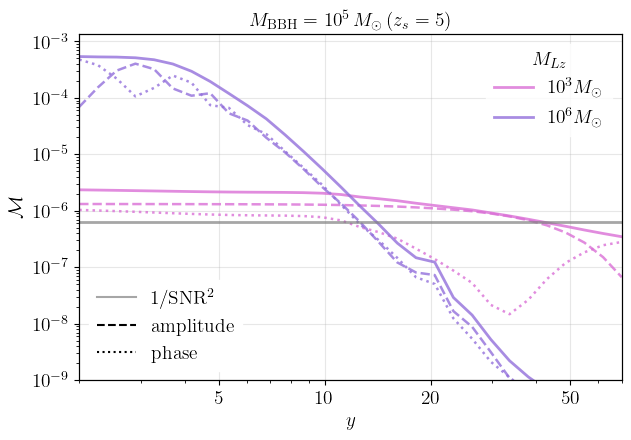

In [40]:
# Instantiate a Psi_SIS object from ln module
Psi_SIS = lenses.Psi_SIS()

# Set up parameters for mismatch calculation
setup = {'phase_only': True, 'amp_only': True}
precision={'p_prec_t_update':{'tmax':1e8}}
pars=setup.copy()
pars.update(precision)

# Generate an array of y values
ys = np.geomspace(2, 70, 30)

# Define specific MLz values and colors for plotting
MLzs = [1e3, 1e6]
cs = ['orchid', 'mediumpurple']

# Specify whether to include phase-only and amplitude-only information
phase_only = False
amp_only = False

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(7, 4.5))

# Plot mismatch curves for different MLz values and colors
for MLz, c in zip(MLzs, cs):
    mmp.plot_mismatch(ax, ys, h_fd, Psi_SIS, MLz, setup=pars, c=c)

# Add legend to the plot based on setup parameters
mmp.add_legend_mismatch(ax, ys, h_fd, **setup)

# Set the title of the plot
ax.set_title(r"$M_{{\rm BBH}}= {:s}\,M_\odot\,(z_s={:s})$".format(tools.latex_float(Mtot), tools.latex_float(z_src_waveform)), fontsize=14)

# Optionally, save the plot to a file
if True:
    plt.savefig('plots/mismatch_ph_amp_'+detector+'_Mbbh_e'+'{:.1f}'.format(np.log10(Mtot))+'.pdf', dpi=700, bbox_inches='tight')


Figure 9

In [41]:
dir='ycr_bank/'
lens='SIS'
s=1

compose_filename_vec=np.vectorize(lambda M, Z: mm.compose_filename(detector, lens, s, M, Z, dir=dir))

In [45]:

Mvirs=np.geomspace(1e5,1e15,100)

Mtot_s=[1e5, 1e6, 1e7]
c1_Mtot_s=['#ffde00', '#ff9200', '#ff3535']

z_src_s=[5, 10]
ls_z_s=["-",  (0, (1, 1))]
# ls_z_s=["-"]

Mtot_grid, z_src_grid = np.meshgrid(Mtot_s, z_src_s)

filename_read_s=compose_filename_vec(Mtot_grid, z_src_grid)
y_crit_fun_s=mm.get_interp_y_crit_from_stored_vec(filename_read_s)


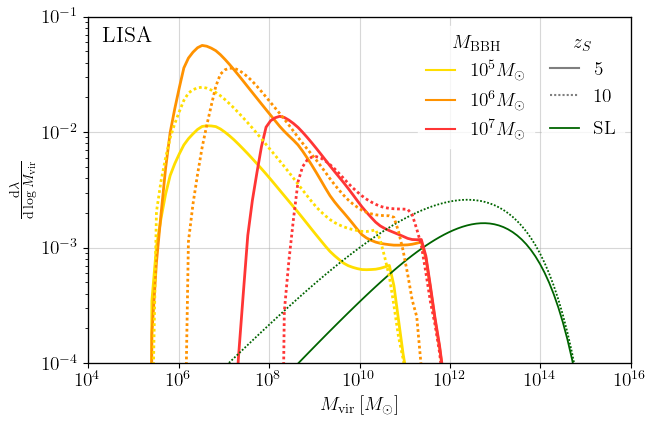

In [46]:
fig, ax= plt.subplots(figsize=(7,4.5))
mmp.plot_dlambda_dlogMvir_curve_vec(ax, Mvirs, y_crit_fun_s, z_src_s, c1_Mtot_s, ls_z_s)
mmp.add_legend_dlambda_dlogMvir(ax, Mtot_s, z_src_s, c1_Mtot_s, ls_z_s, detector)


Figure 10

In [50]:
detector_1='LISA'

compose_filename=np.vectorize(lambda M, Z: mm.compose_filename(detector_1, lens, s, M, Z, dir=dir))

Mvirs=np.geomspace(1e5,1e15,100)

Mtot_1_s=[1e5, 1e6, 1e7]
c1_Mtot_s=['#ffde00', '#ff9200', '#ff3535']

z_src_s=[3, 5, 8, 10]

Mtot_grid, z_src_grid = np.meshgrid(Mtot_1_s, z_src_s)


filename_read_s=compose_filename(Mtot_grid, z_src_grid)
y_crit_fun_s=mm.get_interp_y_crit_from_stored_vec(filename_read_s)

if False:
    plt.savefig('plots/rates'+detector_1+'_zS'+'.pdf', dpi=700, bbox_inches="tight")


In [51]:
# Define detector parameters for the 1st case
detector_1 = 'LISA'

# Use a lambda function to compose filenames for the 1st case
compose_filename_1 = np.vectorize(lambda M, Z: mm.compose_filename(detector_1, lens, s, M, Z, dir=dir))

# Generate an array of Mvir values for the 1st case
Mvirs_1 = np.geomspace(1e5, 1e15, 100)

# Specify Mtot values and colors for plotting in the 1st case
Mtot_1_values = [1e5, 1e6, 1e7]
Mtot_1_colors = ['#ffde00', '#ff9200', '#ff3535']

# Specify source redshift values for the 1st case
z_src_1_values = [3, 5, 8, 10]

# Create a grid of Mtot and z_src values for the 1st case
Mtot_1_grid, z_src_1_grid = np.meshgrid(Mtot_1_values, z_src_1_values)

# Compose filenames based on the grid for the 1st case
filename_read_1_grid = compose_filename_1(Mtot_1_grid, z_src_1_grid)

# Get interpolated y_crit functions from stored vectors for the 1st case
y_crit_fun_1_grid = mm.get_interp_y_crit_from_stored_vec(filename_read_1_grid)

# Optionally, save the plot to a file for the 1st case (disabled in the provided snippet)
if False:
    plt.savefig('plots/rates'+detector_1+'_zS'+'.pdf', dpi=700, bbox_inches="tight")




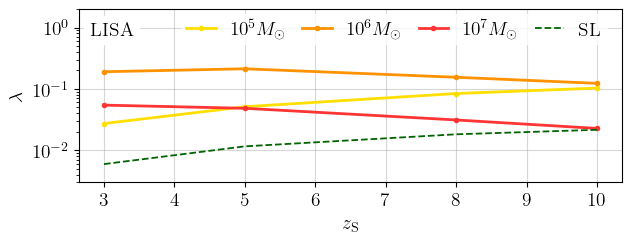

In [52]:
# Create a figure and axis for plotting for the 1st case
fig_1, ax_1 = plt.subplots(1, 1, figsize=(7, 4.5/2))

# Plot n curves on the axis for the 1st case
mmp.plot_lambda(ax_1, z_src_1_values, y_crit_fun_1_grid, Mvirs_1, Mtot_1_values, Mtot_1_colors)

# Add legend to the plot for the 1st case
mmp.add_legend_lambda(ax_1, z_src_1_values, Mtot_1_values, detector_1)

# Optionally, save the plot to a file for the 1st case (disabled in the provided snippet)
if False:
    plt.savefig('plots/rates_' + detector_1 + '_zS' + '.pdf', dpi=700, bbox_inches="tight")


In [112]:
# Define detector parameters for the 2nd case
detector_2 = 'ET'

# Use a lambda function to compose filenames for the 2nd case
compose_filename_2 = np.vectorize(lambda M, Z: mm.compose_filename(detector_2, lens, s, M, Z, dir=dir))

# Generate an array of Mvir values for the 2nd case
Mvirs_2 = np.geomspace(1e0, 1e15, 100)  # LIGO, ET

# Specify Mtot values and colors for plotting in the 2nd case
Mtot_2_values = [50, 1e2, 1e3]
Mtot_2_colors = ['#6efaee', '#0099cc', '#0b377f']  # ET

# Specify source redshift values for the 2nd case
z_src_2_values = [0.6, 1, 3, 5]

# Create a grid of Mtot and z_src values for the 2nd case
Mtot_2_grid, z_src_2_grid = np.meshgrid(Mtot_2_values, z_src_2_values)

# Compose filenames based on the grid for the 2nd case
filename_read_2_grid = compose_filename_2(Mtot_2_grid, z_src_2_grid)

# Get interpolated y_crit functions from stored vectors for the 2nd case
y_crit_fun_2_grid = mm.get_interp_y_crit_from_stored_vec(filename_read_2_grid)



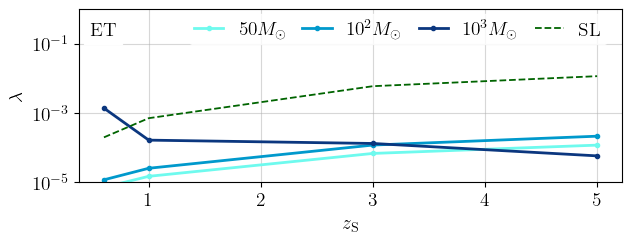

In [113]:
# Create a figure and axis for plotting for the 2nd case
fig_2, ax_2 = plt.subplots(1, 1, figsize=(7, 4.5/2))

# Plot n curves on the axis for the 2nd case
mmp.plot_lambda(ax_2, z_src_2_values, y_crit_fun_2_grid, Mvirs_2, Mtot_2_values, c2_Mtot_s, y_lims=[1e-5,1])

# Add legend to the plot for the 2nd case
mmp.add_legend_lambda(ax_2, z_src_2_values, Mtot_2_values, detector_2)

# Optionally, save the plot to a file for the 2nd case (disabled in the provided snippet)
if False:
    plt.savefig('plots/rates_' + detector_2 + '_zS' + '.pdf', dpi=700, bbox_inches="tight")
